## 전이 학습

- 대용량 데이터셋으로 학습된 모델(pre-trained model)의 **가중치**를 가져와, 원하는 목적에 맞게 보정하여 사용하는 것

  - 특성 추출 기법(Feature Extractor)
  
  - 미세 조정 기법(Fine-tuning)

---

#### 특성 추출 기법

- pre-trained model을 가져와서

- Conv Layer들의 가중치는 그대로 사용하고

- 마지막 **FC Layer 부분만** 새로 만들어 사용하는 방식

  - 즉, 마지막 FC Layer 부분만 학습되는 것

<img src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2019/06/fine_tuning_keras_freeze_unfreeze.png?lossy=1&strip=1&webp=1" width="450px">

##### (1) 라이브러리 호출

In [33]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

##### (2) 학습 데이터 다운로드 및 전처리

In [ ]:
!git clone 'https://github.com/gilbutITbook/080289.git'

In [21]:
data_path = '/content/080289/chap05/data/catanddog/train'

transform = transforms.Compose( # 이미지 변환
    [
        transforms.Resize([256, 256]), # 256x256 사이즈 조정
        transforms.RandomResizedCrop(224), # 랜덤으로 Crop
        transforms.RandomHorizontalFlip(), # 랜덤으로 수평 Flip
        transforms.ToTensor() # Tensor로 변환
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    root=data_path, # 데이터 경로
    transform=transform # 데이터 전처리
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, # DataLoader로 데이터 불러오기
    batch_size=32, # 한 번에 불러올 데이터 양
    num_workers=8,
    shuffle=True
)

len(train_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


385

*RandomResizedCrop*

In [ ]:
!pip install mxnet
# !pip install --user mxnet

In [23]:
import mxnet as mx
from mxnet.gluon.data.vision import transforms

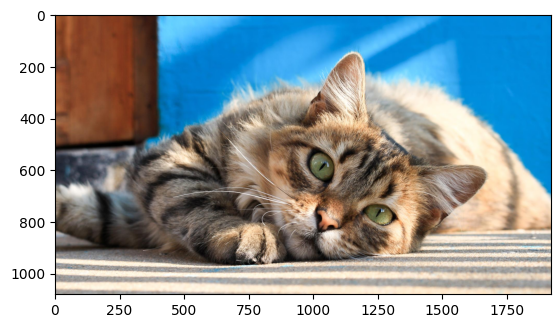

In [30]:
# 원본 이미지
example = mx.image.imread('/content/080289/chap05/data/cat.jpg')
plt.imshow(example.asnumpy())

In [28]:
# 시각화를 위한 함수
def show_images(imgs, num_rows, num_cols, scale=2):
    aspect_ratio = imgs[0].shape[0]/imgs[0].shape[1]
    figsize = (num_cols * scale, num_rows * scale * aspect_ratio)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i*num_cols+j].asnumpy())
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.1, wspace=0)
    return axes

def apply(img, aug, num_rows=2, num_cols=4, scale=3):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

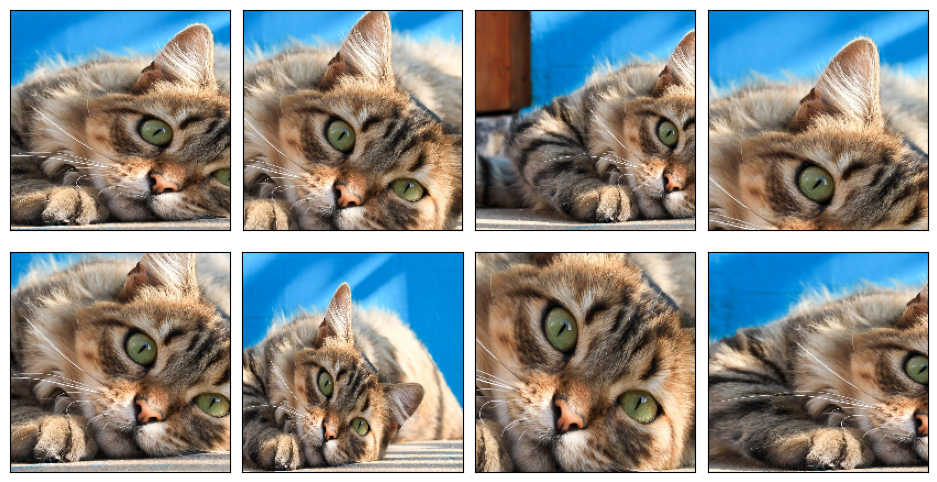

In [32]:
# RandomResizedCrop 적용 이미지
shape_aug = transforms.RandomResizedCrop(
    size=(200, 200), # 사이즈 조정 : 200x200
    scale=(0.1, 1), # 면적의 비율 조정 : 10~100% 범위에서 랜덤으로
    ratio=(0.5, 2) # 너비-높이 비율 조정 : 0.5~2 범위에서 랜덤으로
)

apply(example, shape_aug)

*학습 데이터 시각화*

In [ ]:
samples, labels = next(iter(train_loader))
classes = {0 : 'cat', 1 : 'dog'}

fig = plt.figure(figsize=(16, 24))
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

##### (3) 모델 생성

- pre-trained model 내려받기

In [212]:
import torchvision.models as models

vgg16 = models.vgg16() # 랜덤한 가중치 사용
resnet18 = models.resnet18(pretrained=True) # pretrained=True : 사전 학습된 가중치를 그대로 사용

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


- 모델의 파라미터 학습 유무 설정

    - Conv Layer는 고정하고 FC Layer만 학습시킬 때,
    
    - 역전파 중 Conv Layer 파라미터의 변화를 계산할 필요가 없음

In [213]:
def set_parameter(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터의 변화를 계산하지 않음

In [214]:
set_parameter(resnet18)

- pre-trained model의 FC Layer를 새롭게 변경

In [215]:
resnet18.fc = nn.Linear(512, 2)

In [216]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 파라미터의 변화를 계산하는 Layer : **새로 추가한 FC Layer** -> Train

In [217]:
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        print(name, param.data)

fc.weight tensor([[ 0.0315, -0.0008,  0.0244,  ..., -0.0187,  0.0361,  0.0050],
        [-0.0123,  0.0139,  0.0307,  ..., -0.0150,  0.0332, -0.0120]])
fc.bias tensor([-0.0197, -0.0123])


- 파라미터의 변화를 계산하지 않는 Layer : **그대로 사용할 Conv Layer** -> Freeze

In [218]:
for name, param in resnet18.named_parameters():
    if param.requires_grad == False:
        print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

##### (4) 파라미터 설정

- 추가된 FC Layer는 학습시켜야 함

- FC Layer의 파라미터(weight, bias)만 **옵티마이저**에 전달하여 모델 학습에 사용함

In [220]:
params_to_update = []

for name, param in resnet18.named_parameters():
    if param.requires_grad == True: # 추가된 FC Layer의 파라미터
        params_to_update.append(param)
        print(name)

fc.weight
fc.bias


- 옵티마이저는 전달된 파라미터에 대해서만 gradient를 계산하고 업데이트함

In [222]:
optimizer = torch.optim.Adam(params_to_update)

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

##### (5) 모델 학습

In [114]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders: # DataLoader에 전달된 이미지 수만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print(f"Loss: {epoch_loss:.4} Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/080289/chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch))) # 학습된 모델 저장
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history, loss_history

In [112]:
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/13
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.7436 Acc: 0.5221

Epoch 1/13
----------
Loss: 0.4468 Acc: 0.7948

Epoch 2/13
----------
Loss: 0.3387 Acc: 0.8649

Epoch 3/13
----------
Loss: 0.2901 Acc: 0.8935

Epoch 4/13
----------
Loss: 0.2838 Acc: 0.8909

Epoch 5/13
----------
Loss: 0.2231 Acc: 0.9351

Epoch 6/13
----------
Loss: 0.2096 Acc: 0.9403

Epoch 7/13
----------
Loss: 0.2243 Acc: 0.9013

Epoch 8/13
----------
Loss: 0.1967 Acc: 0.9247

Epoch 9/13
----------
Loss: 0.2129 Acc: 0.9143

Epoch 10/13
----------
Loss: 0.2116 Acc: 0.9377

Epoch 11/13
----------
Loss: 0.2757 Acc: 0.8701

Epoch 12/13
----------
Loss: 0.2615 Acc: 0.8805

Training complete in 10m 9s
Best Acc: 0.940260


##### (6) 모델 검증

In [115]:
test_path = '/content/080289/chap05/data/catanddog/test'

transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

len(test_dataset)

98

In [116]:
def test_model(model, dataloaders, device):
    since = time.time() # 현재 시각
    acc_history = []

    best_acc = 0.0

    saved_models = glob.glob('/content/080289/chap05/data/catanddog/' + '*.pth') # 저장한 모델들에 접근
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path)) # 저장한 모델을 불러옴
        model.eval()
        model.to(device)

        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # autograd 사용하지 않음
                outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print(f"Acc: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [119]:
val_acc_hist = test_model(resnet18, test_loader, device)

saved_model ['/content/080289/chap05/data/catanddog/00.pth', '/content/080289/chap05/data/catanddog/01.pth', '/content/080289/chap05/data/catanddog/02.pth', '/content/080289/chap05/data/catanddog/03.pth', '/content/080289/chap05/data/catanddog/04.pth', '/content/080289/chap05/data/catanddog/05.pth', '/content/080289/chap05/data/catanddog/06.pth', '/content/080289/chap05/data/catanddog/07.pth', '/content/080289/chap05/data/catanddog/08.pth', '/content/080289/chap05/data/catanddog/09.pth', '/content/080289/chap05/data/catanddog/10.pth', '/content/080289/chap05/data/catanddog/11.pth', '/content/080289/chap05/data/catanddog/12.pth']
Loading model /content/080289/chap05/data/catanddog/00.pth
Acc: 0.7551

Loading model /content/080289/chap05/data/catanddog/01.pth
Acc: 0.8878

Loading model /content/080289/chap05/data/catanddog/02.pth
Acc: 0.8776

Loading model /content/080289/chap05/data/catanddog/03.pth
Acc: 0.8878

Loading model /content/080289/chap05/data/catanddog/04.pth
Acc: 0.9184

Loa

##### (7) 학습 결과

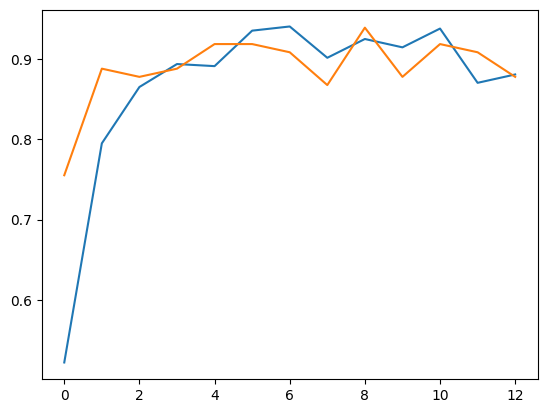

In [121]:
plt.plot(train_acc_hist) # 학습 데이터 정확도
plt.plot(val_acc_hist) # 테스트 데이터 정확도
plt.show()

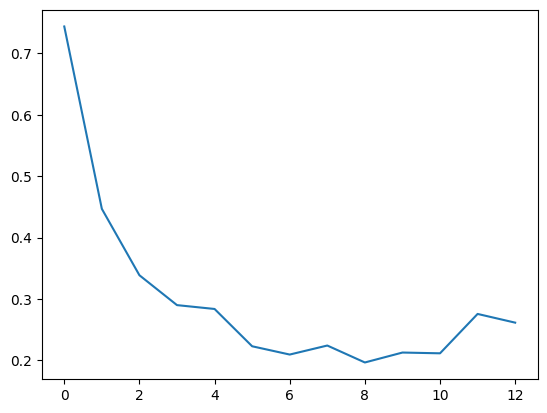

In [123]:
plt.plot(train_loss_hist) # 학습 데이터 손실함수 값
plt.show()

##### (8) 테스트

In [124]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # 기존 Tensor를 복사하지만, 기울기에 영향을 주지는 않음
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1) # 값을 0~1 사이로 제한함
    return image

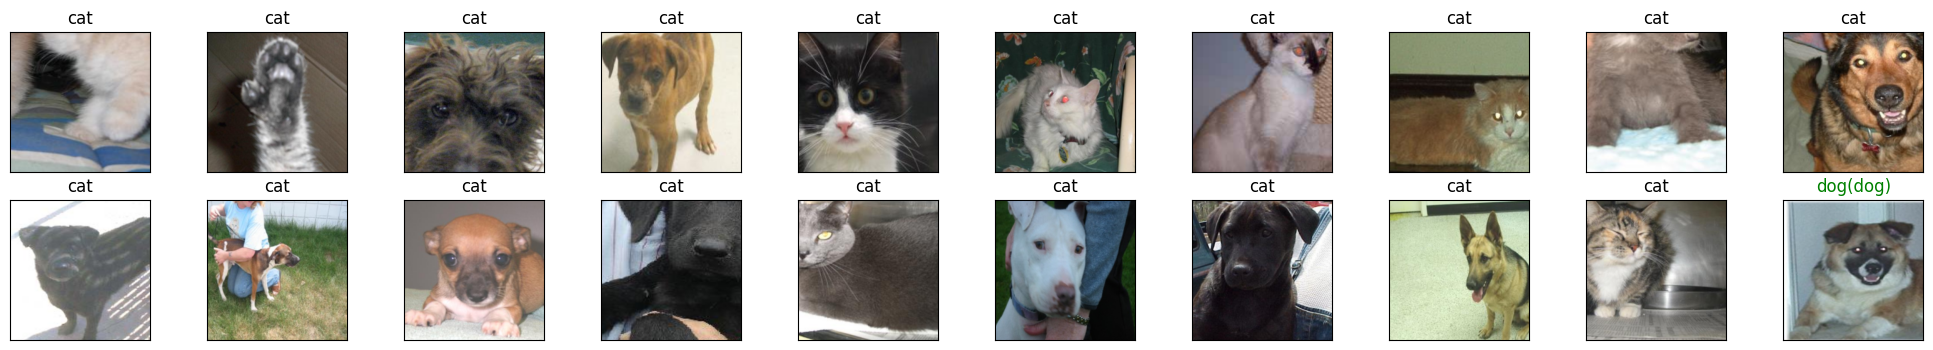

<Figure size 640x480 with 0 Axes>

In [136]:
classes = {0 : 'cat', 1 : 'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)
output = resnet18(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[i].item()])
ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=('green' if preds[idx]==labels[idx] else 'red'))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

---

#### 미세 조정 기법

- pre-trained model에서 FC Layer만 새롭게 학습시키는 특성 추출 기법에서 더 나아가,

- **그 외 Layer**들의 파라미터도 재학습시키는 것

(1) 학습 데이터셋이 크고, pre-trained model과 유사성이 작은 경우

  - 모델 전체를 재학습시키기

(2) 학습 데이터셋이 크고, pre-trained model과 유사성이 큰 경우

  - Conv Layer의 **뒷부분**과 FC Layer를 학습시키기

(3) 학습 데이터셋이 작고, pre-trained model과 유사성이 작은 경우

  - Conv Layer의 일부분과 FC Layer를 학습시키기

(4) 학습 데이터셋이 작고, pre-trained model과 유사성이 큰 경우

  - **FC Layer만** 학습시키기